# Example 4: 2nd-level Analysis

Last but not least, the 2nd-level analysis. After we removed left-handed subjects and normalized all subject data into template space, we can now do the group analysis. To show the flexibility of Nipype, we will run the group analysis on data and two different normalizations (ANTs and SPM).

# Group Analysis with SPM

In [27]:
from nilearn import plotting
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import OneSampleTTestDesign, EstimateModel, EstimateContrast, Threshold
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Experiment parameters (SPM12)

In [40]:
experiment_dir = '/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/'
output_dir = 'datasink'

contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005', 'con_0006', 'con_0007', 'con_0008', 'con_0009']

mask = '/home/neuro/Data/Visual_search_task/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz' 

## Specify Nodes (SPM12)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [41]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(), name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}), name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True), name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

## Specify input & output stream (SPM12)

Specify where the input data can be found & where and how to save the output data.

In [69]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id']), name="infosource")
infosource.iterables = [('contrast_id', contrast_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': '/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-*/w{contrast_id}.nii'}
selectfiles = Node(SelectFiles(templates, sort_filelist=True), name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir, container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
datasink.inputs.substitutions = substitutions

## Specify Workflow (SPM12)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [67]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = experiment_dir

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file', 'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file', 'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file', 'spm_mat_file'),
                                                         ('beta_images', 'beta_images'),
                                                         ('residual_image', 'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file', 'spm_mat_file'),
                                                       ('spmT_images', 'stat_image')]),
                    (level2conestimate, datasink, [('spm_mat_file', '2ndLevel.@spm_mat'),
                                                   ('spmT_images', '2ndLevel.@T'),
                                                   ('con_images', '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map', '2ndLevel.@threshold')])
                    ])

## Visualize the workflow (SPM12)

It always helps to visualize your workflow.

In [48]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

211118-14:56:12,555 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/2nd_analysis/new_result/spm_l2analysis/graph.png (graph2use=colored, simple_form=True).


'/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/spm_l2analysis/graph.png'

##  Run the Workflow (SPM12)

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [68]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

211118-15:44:30,733 nipype.workflow INFO:
	 Workflow spm_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
211118-15:44:30,799 nipype.workflow INFO:
	 Running in parallel.
211118-15:44:30,802 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 8 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211118-15:44:30,941 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/spm_l2analysis/_contrast_id_con_0007/selectfiles".
211118-15:44:30,948 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/spm_l2analysis/_contrast_id_con_0006/selectfiles".
211118-15:44:30,956 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/spm_l2analysis/_contrast_id_con_0005/selectfiles".
211118-15:44:30,964 nipype.workflow INFO:

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211118-15:44:40,258 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.onesampttestdes".


stty: 'standard input': Inappropriate ioctl for device


211118-15:44:40,817 nipype.workflow ERROR:
	 Node onesampttestdes.a6 failed to run on host 9a23e6b9473d.
211118-15:44:40,818 nipype.workflow ERROR:
	 Saving crash info to /work/crash-20211118-154440-neuro-onesampttestdes.a6-73ea929f-17e8-4597-b02d-25ee6ba6eab7.pklz
Traceback (most recent call last):
  File "/src/nipype/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 516, in run
    result = self._run_interface(execute=True)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 635, in _run_interface
    return self._run_command(execute)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 741, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/src/nipype/nipype/interfaces/base/core.py", line 398, in run
    runtime = self._run_interface(runtime)
  File "/src/nipype/nipype/interfaces/spm/base.py", line 387, in _run_interface
    resu

stty: 'standard input': Inappropriate ioctl for device


211118-15:44:46,370 nipype.workflow INFO:
	 [Node] Finished "spm_l2analysis.onesampttestdes".


stty: 'standard input': Inappropriate ioctl for device


211118-15:44:46,552 nipype.workflow WARNING:
	 Storing result file without outputs
211118-15:44:46,564 nipype.workflow WARNING:
	 [Node] Error on "spm_l2analysis.onesampttestdes" (/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/spm_l2analysis/_contrast_id_con_0003/onesampttestdes)


stty: 'standard input': Inappropriate ioctl for device


211118-15:44:46,821 nipype.workflow ERROR:
	 Node onesampttestdes.a2 failed to run on host 9a23e6b9473d.
211118-15:44:46,822 nipype.workflow ERROR:
	 Saving crash info to /work/crash-20211118-154446-neuro-onesampttestdes.a2-3997b0ce-0d4e-42c5-b076-c583beb8f0ab.pklz
Traceback (most recent call last):
  File "/src/nipype/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 516, in run
    result = self._run_interface(execute=True)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 635, in _run_interface
    return self._run_command(execute)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 741, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/src/nipype/nipype/interfaces/base/core.py", line 398, in run
    runtime = self._run_interface(runtime)
  File "/src/nipype/nipype/interfaces/spm/base.py", line 387, in _run_interface
    resu

stty: 'standard input': Inappropriate ioctl for device


211118-15:44:52,824 nipype.workflow ERROR:
	 Node level2estimate.a5 failed to run on host 9a23e6b9473d.
211118-15:44:52,825 nipype.workflow ERROR:
	 Saving crash info to /work/crash-20211118-154452-neuro-level2estimate.a5-72887116-4847-4951-8922-47c75ac5a40a.pklz
Traceback (most recent call last):
  File "/src/nipype/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 516, in run
    result = self._run_interface(execute=True)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 635, in _run_interface
    return self._run_command(execute)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 741, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/src/nipype/nipype/interfaces/base/core.py", line 398, in run
    runtime = self._run_interface(runtime)
  File "/src/nipype/nipype/interfaces/spm/base.py", line 387, in _run_interface
    result

stty: 'standard input': Inappropriate ioctl for device


211118-15:44:56,844 nipype.workflow ERROR:
	 Node level2estimate.a1 failed to run on host 9a23e6b9473d.
211118-15:44:56,849 nipype.workflow ERROR:
	 Saving crash info to /work/crash-20211118-154456-neuro-level2estimate.a1-395020f3-df91-4b94-a191-60ccfbb44f7d.pklz
Traceback (most recent call last):
  File "/src/nipype/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 516, in run
    result = self._run_interface(execute=True)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 635, in _run_interface
    return self._run_command(execute)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 741, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/src/nipype/nipype/interfaces/base/core.py", line 398, in run
    runtime = self._run_interface(runtime)
  File "/src/nipype/nipype/interfaces/spm/base.py", line 387, in _run_interface
    result

RuntimeError: Workflow did not execute cleanly. Check log for details

# Group Analysis with ANTs

Now to run the same group analysis, but on the ANTs normalized images, we just need to change a few parameters:

In [51]:
# Change the SelectFiles template and recreate the node
templates = {'cons': '/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_ants/norm_ants/sub-*/{contrast_id}_trans.nii'}
selectfiles = Node(SelectFiles(templates, sort_filelist=True), name="selectfiles")

# Change the substituion parameters for the datasink
substitutions = [('_contrast_id_', '')]
datasink.inputs.substitutions = substitutions

Now, we just have to recreate the workflow.

In [64]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='ants_l2analysis')
l2analysis.base_dir = opj(experiment_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file', 'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file', 'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file', 'spm_mat_file'),
                                                         ('beta_images', 'beta_images'),
                                                         ('residual_image', 'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file', 'spm_mat_file'),
                                                       ('spmT_images', 'stat_image')]),
                    (level2conestimate, datasink, [('spm_mat_file', '2ndLevel.@spm_mat'),
                                                   ('spmT_images', '2ndLevel.@T'),
                                                   ('con_images', '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map', '2ndLevel.@threshold')])])

In [65]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

211118-15:42:57,479 nipype.workflow INFO:
	 Workflow ants_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
211118-15:42:57,541 nipype.workflow INFO:
	 Running in parallel.
211118-15:42:57,544 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 8 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211118-15:42:57,708 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/ants_l2analysis/_contrast_id_con_0007/selectfiles".
211118-15:42:57,715 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/ants_l2analysis/_contrast_id_con_0006/selectfiles".
211118-15:42:57,725 nipype.workflow INFO:
	 [Node] Setting-up "ants_l2analysis.selectfiles" in "/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/ants_l2analysis/_contrast_id_con_0005/selectfiles".
211118-15:42:57,736 nipype.workflo

stty: 'standard input': Inappropriate ioctl for device


211118-15:43:07,193 nipype.workflow WARNING:
	 Storing result file without outputs
211118-15:43:07,205 nipype.workflow WARNING:
	 [Node] Error on "spm_l2analysis.onesampttestdes" (/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/spm_l2analysis/_contrast_id_con_0006/onesampttestdes)
211118-15:43:07,284 nipype.workflow WARNING:
	 Storing result file without outputs
211118-15:43:07,284 nipype.workflow WARNING:
	 Storing result file without outputs
211118-15:43:07,296 nipype.workflow WARNING:
	 [Node] Error on "spm_l2analysis.onesampttestdes" (/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/spm_l2analysis/_contrast_id_con_0007/onesampttestdes)
211118-15:43:07,297 nipype.workflow WARNING:
	 [Node] Error on "spm_l2analysis.onesampttestdes" (/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/spm_l2analysis/_contrast_id_con_0005/onesampttestdes)


stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input'stty: : Inappropriate ioctl for device'standard input'
: Inappropriate ioctl for device


211118-15:43:07,556 nipype.workflow ERROR:
	 Node onesampttestdes.a6 failed to run on host 9a23e6b9473d.
211118-15:43:07,558 nipype.workflow ERROR:
	 Saving crash info to /work/crash-20211118-154307-neuro-onesampttestdes.a6-f0997305-6067-4b53-af10-c92935a1913c.pklz
Traceback (most recent call last):
  File "/src/nipype/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 516, in run
    result = self._run_interface(execute=True)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 635, in _run_interface
    return self._run_command(execute)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 741, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/src/nipype/nipype/interfaces/base/core.py", line 398, in run
    runtime = self._run_interface(runtime)
  File "/src/nipype/nipype/interfaces/spm/base.py", line 387, in _run_interface
    resu

stty: 'standard input': Inappropriate ioctl for device


211118-15:43:13,563 nipype.workflow ERROR:
	 Node onesampttestdes.a1 failed to run on host 9a23e6b9473d.
211118-15:43:13,564 nipype.workflow ERROR:
	 Saving crash info to /work/crash-20211118-154313-neuro-onesampttestdes.a1-bb76c1e2-d8f8-49dc-8666-aef1529113ce.pklz
Traceback (most recent call last):
  File "/src/nipype/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 516, in run
    result = self._run_interface(execute=True)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 635, in _run_interface
    return self._run_command(execute)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 741, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/src/nipype/nipype/interfaces/base/core.py", line 398, in run
    runtime = self._run_interface(runtime)
  File "/src/nipype/nipype/interfaces/spm/base.py", line 387, in _run_interface
    resu

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211118-15:43:15,569 nipype.workflow ERROR:
	 Node onesampttestdes.a2 failed to run on host 9a23e6b9473d.
211118-15:43:15,569 nipype.workflow ERROR:
	 Saving crash info to /work/crash-20211118-154315-neuro-onesampttestdes.a2-cb2bdddf-3477-4be6-9a82-92f234015db6.pklz
Traceback (most recent call last):
  File "/src/nipype/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 516, in run
    result = self._run_interface(execute=True)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 635, in _run_interface
    return self._run_command(execute)
  File "/src/nipype/nipype/pipeline/engine/nodes.py", line 741, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/src/nipype/nipype/interfaces/base/core.py", line 398, in run
    runtime = self._run_interface(runtime)
  File "/src/nipype/nipype/interfaces/spm/base.py", line 387, in _run_interface
    resu

RuntimeError: Workflow did not execute cleanly. Check log for details

# Visualize results

Now we create a lot of outputs, but how do they look like? And also, what was the influence of different smoothing kernels and normalization?

**Keep in mind, that the group analysis was only done on *`N=7`* subjects, and that we chose a voxel-wise threshold of *`p<0.005`*. Nonetheless, we corrected for multiple comparisons with a cluster-wise FDR threshold of *`p<0.05`*.**

So let's first look at the contrast **average**:

In [55]:
from nilearn.plotting import plot_stat_map
anatimg = '/home/neuro/Data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


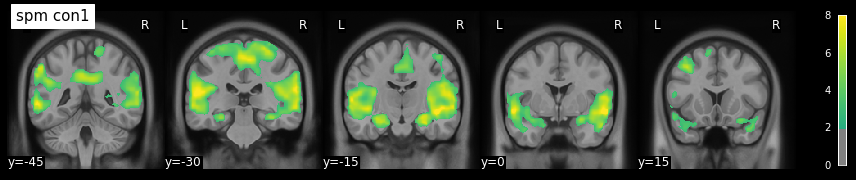

In [60]:
plot_stat_map(
    '/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/datasink_spm/2ndLevel/con_0001/spmT_0001_thr.nii', title='spm con1', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

The results are more or less what you would expect: The peaks are more or less at the same places for the two normalization approaches and a wider smoothing has the effect of bigger clusters, while losing the sensitivity for smaller clusters.

Now, let's see other contrast -- **Finger > others**. Since we removed left-handed subjects, the activation is seen on the left part of the brain.

/opt/miniconda-latest/envs/neuro/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


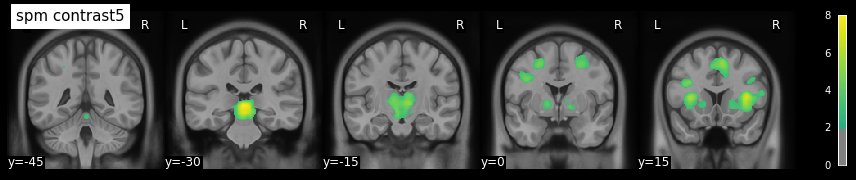

In [62]:
plot_stat_map(
    '/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/datasink_spm/2ndLevel/con_0005/spmT_0001_thr.nii', title='spm contrast5', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

Now, let's see the results using the glass brain plotting method.

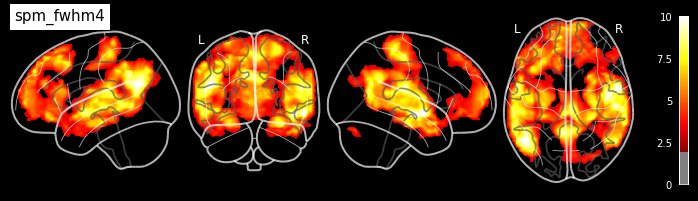

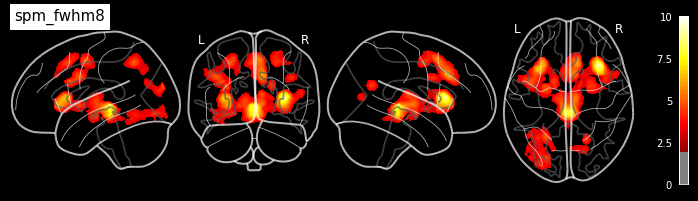

In [63]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/datasink_spm/2ndLevel/con_0001/spmT_0001_thr.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='spm_fwhm4')
# plot_glass_brain(
#     '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001_thr.nii', colorbar=True,
#     threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm4');
plot_glass_brain(
    '/home/neuro/Result/Visual_search_task/2nd_analysis/new_result/datasink_spm/2ndLevel/con_0005/spmT_0001_thr.nii', colorbar=True,
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='spm_fwhm8')
# plot_glass_brain(
#     '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/2ndLevel/ants_con_0005_fwhm8/spmT_0001_thr.nii', colorbar=True,
#     threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm8');